In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from PMFBSS import *
# np.random.seed(100)
%load_ext autoreload
%autoreload 2

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = True)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
Y = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(Y.shape[0], Y.shape[1])
Y = Y  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(Y, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 27.11870423179561


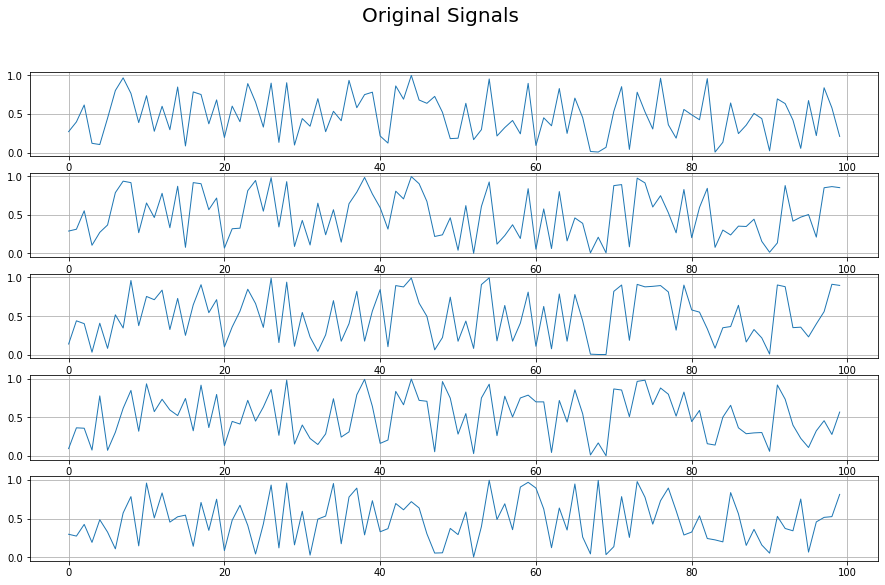

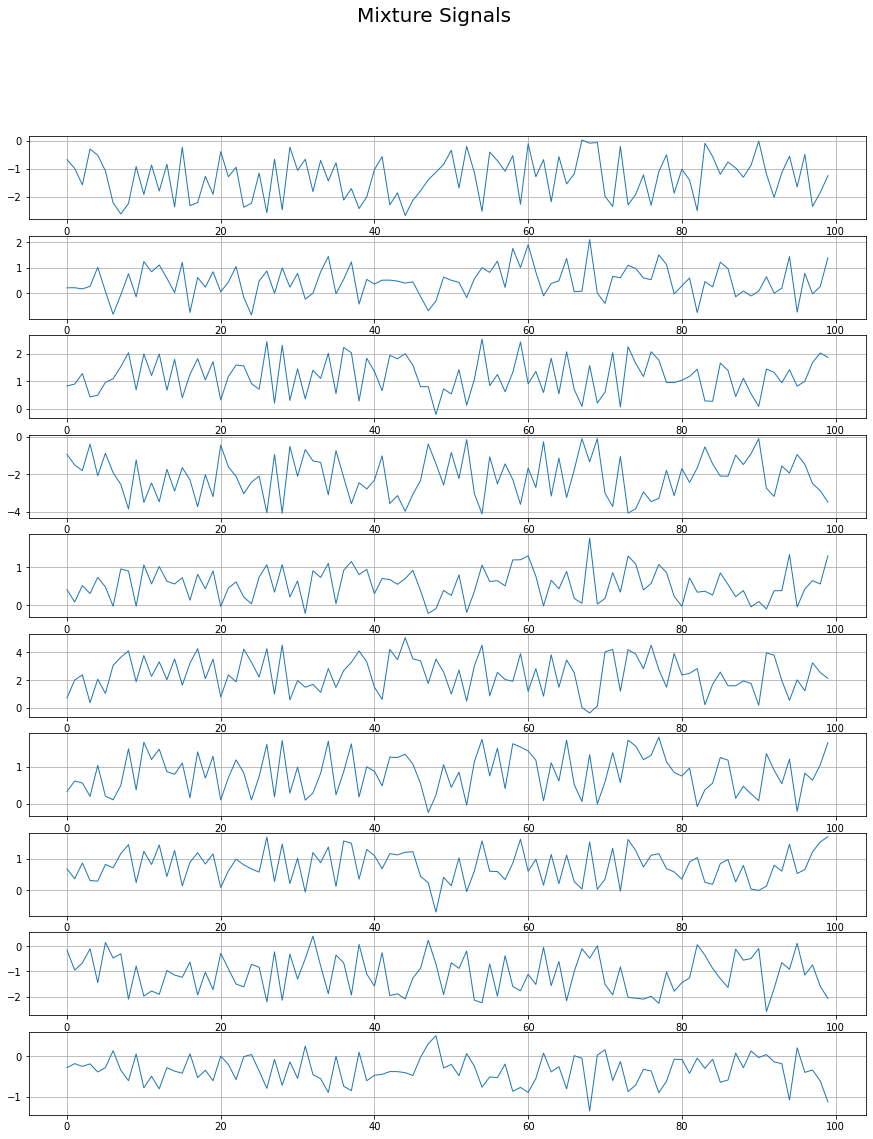

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(Y.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [5]:
lambda_ = 1 - 1e-2
beta = 50
s_dim = S.shape[0]
y_dim = Y.shape[0]

# Inverse output covariance
B = 5 * np.eye(s_dim)


debug_iteration_point = 1000
model = OnlinePMF(s_dim = s_dim, y_dim = y_dim, muW = 1e-3, lambda_ = lambda_,
                  beta = beta, B = B, neural_OUTPUT_COMP_TOL = 1e-6,
                  set_ground_truth = True, Sgt = S, A = A)

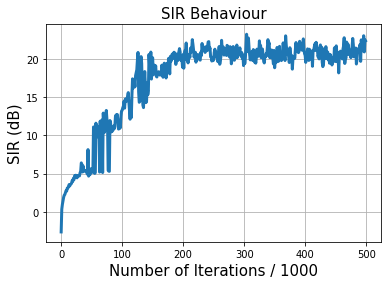

100%|█████████████████████████████████| 500000/500000 [02:04<00:00, 4025.10it/s]


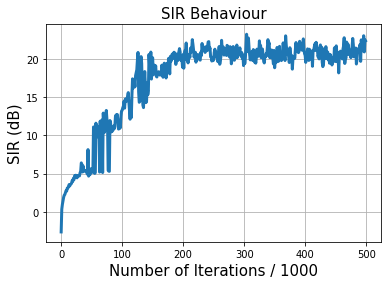

In [6]:
model.fit_batch_nnantisparse(Y = Y, n_epochs = 1, neural_dynamic_iterations = 500,
                             plot_in_jupyter = True, 
                             neural_lr_start = 1.5, neural_lr_stop = 1e-10,
                             debug_iteration_point = debug_iteration_point, 
                             shuffle = True)

Final SIR: 22.425081907823312


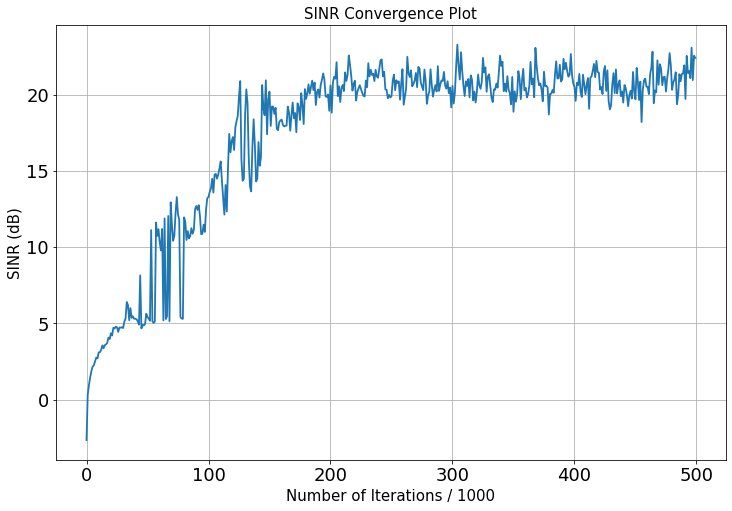

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Shat = Wf @ Y
Shat.shape, Y.shape, S.shape

((5, 500000), (10, 500000), (5, 500000))

In [9]:
Shat_ = signed_and_permutation_corrected_sources(S.T,Shat.T).T

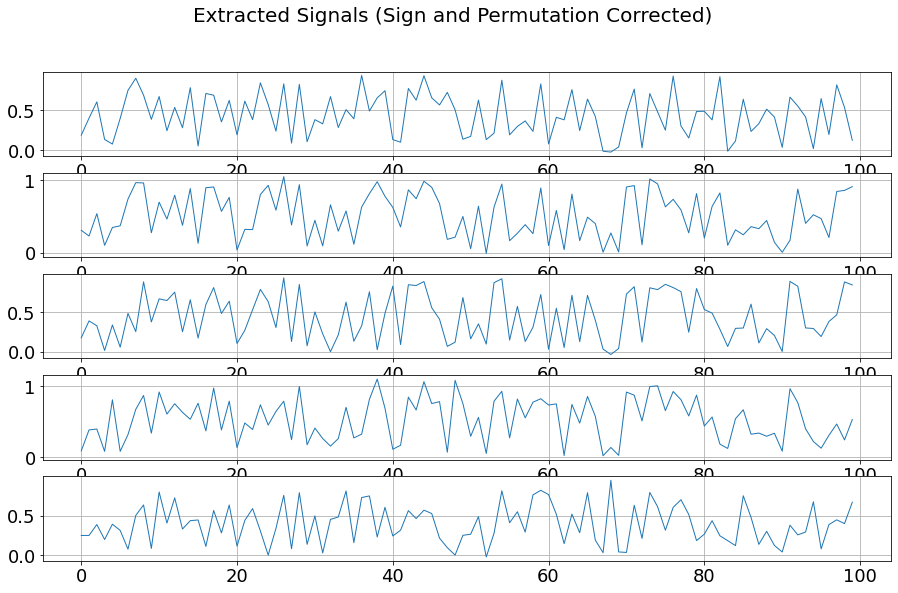

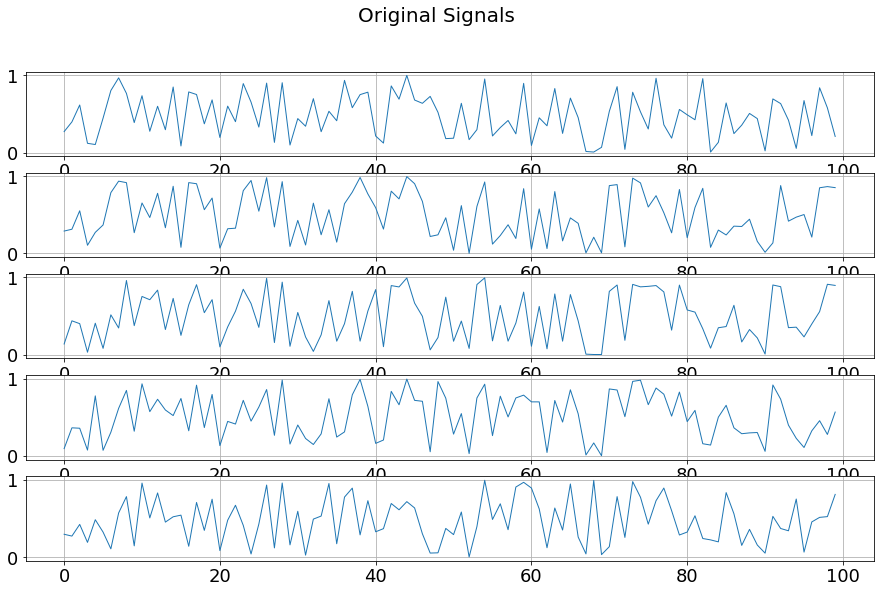

In [10]:
subplot_1D_signals(X = Shat_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)